In [1]:
import glob
import os
import sys
import smrclib
from tqdm import tqdm_notebook as tqdm

In [2]:
try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

In [3]:
import carla
import random
import time
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
SECONDS_PER_EPISODE = 12
brake_count = 0
crash_count = 0
timeout_count = 0
RuntimeError_count = 0

In [4]:
def xxx():
    for actor in env.actor_list:
        actor.destroy()

In [5]:
def update_q(state,new_state,action,reward):
    global learning_rate,discount_rate,q_table,dist_q
    if state == new_state:
        if state in dist_q  :
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)        
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        else :
            dist_q.append(state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0,0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
    else:
        if state in dist_q and new_state in dist_q :
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        elif state in dist_q :
            dist_q.append(new_state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(new_st,[0,0,0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        elif new_state in dist_q:
            dist_q.append(state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0,0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        else :
            dist_q.append(state)
            dist_q.append(new_state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0,0,0])
            q_table.insert(new_st,[0,0,0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
            print('NONE')

In [7]:
class CarEnv:
    #BRAKE_AMT = 1.0
    actor_list = []
    collision_hist = []
    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)
        self.world = self.client.get_world()
        blueprint_library = self.world.get_blueprint_library()
        self.model_3 = blueprint_library.filter('model3')[0]
        # enable no-rendering mode
        self.settings = self.world.get_settings()
        self.settings.no_rendering_mode = False
        self.world.apply_settings(self.settings)
        
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []
        #place=random.uniform(110,150)
        place=random.uniform(120,150)
        #transform = carla.Transform(carla.Location(-120,place,3),carla.Rotation(0,-90,0))
        transform = carla.Transform(carla.Location(place,60,3),carla.Rotation(0,180,0))
        self.flag = 0
        self.vehicle = self.world.spawn_actor(self.model_3, transform)
        self.flag = 1
        self.actor_list.append(self.vehicle)
        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')
        transform = carla.Transform(carla.Location(x=0, z=1.9))
        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))
        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        self.episode_start = time.time()
        time.sleep(4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))
        while self.distance_to_obstacle is None:
            time.sleep(0.01)
        self.episode_start = time.time()
        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        return abs(float("%.1f" % self.distance_to_obstacle))

    def collision_data(self, event):
        self.collision_hist.append(str('collision with '+ str(event.other_actor)[0:-1].split('.')[1]))
        #impulse = event.normal_impulse
        #intensity = math.sqrt(impulse.x**2 + impulse.y**2 + impulse.z**2)
        
    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        self.pt_cloud.append(points)
        #screen points specifically -4<y<4 and 0<x<12
        
        #front recognition
        points = points[np.logical_and(points[:,0] > -3, points[:,0] < 3)]
        points = points[np.logical_and(points[:,1] > 0, points[:,1] < 1000)]
        points = points[np.logical_and(points[:,2] > -1.75, points[:,2] < 1000)]
        self.pt_cloud_filtered.append(points)
        if len(points) == 0:
            pass
        else:
            self.distance_to_obstacle = min(points[:,1])-2.247148275375366 # ลบ ระยะหน้ารถ
        
        #left recognition
        #right recognition

    def step(self, action):
        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.0)) #accelerate
        elif action == 1:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.3, steer = 0.0)) #brake
        elif action == 2:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.5, steer = 0.0))
        elif action == 3:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=1.0, steer = 0.0))
        global brake_count, crash_count, timeout_count
        if kmh == 0 and len(self.collision_hist) == 0:
            print('---- terminal end: brake ----')
            done = True
            reward = (self.distance_to_obstacle+2)*(self.distance_to_obstacle-10)*(self.distance_to_obstacle-10)/2
            brake_count += 1
        elif len(self.collision_hist) != 0 :
            print('---- terminal end: crash ----')
            done = True
            reward = -20
            crash_count += 1
        else:
            done = False
            # รถอยู่ในโซนเบรค
            if self.distance_to_obstacle <= 10:
                reward = -0.1
            # รถไม่ได้อยู่ในโซนเบรค
            else:
                reward = 0.05
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            print('---- terminal end: Time up ----')
            reward = -10
            dist = 0
            timeout_count +=1
        dist=abs(float("%.1f" % self.distance_to_obstacle))
        return dist, reward, done, None

In [9]:
ttttt = time.time()
env = CarEnv()
action_space_size = 2
state_space_size = 10
#q_table = np.zeros((state_space_size, action_space_size))
q_table = []
dist_q=[]

num_episodes = 300
learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

count = 0
rewards_all_episodes = []
action_all_episodes = []

for episode in tqdm(range(num_episodes)):
    # reset state, but sometimes the server will lag so except the error then reconnect to the server after time.sleep() for 15 sec
    while True:
        try:
            state = env.reset()
            if env.flag == 1:
                break
        except RuntimeError as err:
            RuntimeError_count += 1
            print(err,' ',1)
            while True:
                try:
                    time.sleep(15)  #wait for 15 sec
                    env.client = carla.Client('localhost', 2000) #reconnect to server
                    env.client.set_timeout(10.0)
                    env.world = env.client.get_world()  #if cannot reconnect, this line will cause an error ---> jump to the 'except' line
                    blueprint_library = env.world.get_blueprint_library()
                    env.model_3 = blueprint_library.filter('model3')[0]
                    env.world.wait_for_tick()
                    for x in list(world.get_actors())[-3:]:
                        x.destroy() #destroy the last episode vehicle, lidar and collision sensor
                    break
                except RuntimeError as err:
                    RuntimeError_count += 1
                    print(err,' ',RuntimeError_count)
    ss=time.time()-env.episode_start
    print('LOOP START :'+str(ss))
    done = False
    rewards_current_episode = []
    action_current_episode = []
    count_step=0
    
    while True:
        #print(state)
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            #action = np.argmax(q_table[state,:]) 
            #print('YEAH')
            if state not in dist_q:
                break
            action=q_table[dist_q.index(state)].index(max(q_table[dist_q.index(state)][:]))
        else:
            #print('DAMN_BRO')
            action = np.random.randint(0, high=4, size=None, dtype='int')
            time.sleep(0.1)
            
        action_current_episode.append(action)
        
        new_state, reward, done, info = env.step(action)
        
        update_q(state,new_state,action,reward)
        count_step+=1
        state = new_state
        rewards_current_episode.append(reward)
                    
        if done == True:
            break  
    
    print(env.vehicle.get_velocity())
    print('destroying actors')
    for actor in env.actor_list:
                actor.destroy()
    time.sleep(0.1)
    
    print(np.array(q_table))
    count+=1
    print('episode number = ',count)
    #print('distance to obstacle = ',state)
    #print('rewards_current_episode = ',rewards_current_episode)
    print('action_current_episode =', action_current_episode)
    print('count_step = ', count_step)
    print(env.collision_hist)
    
    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
          (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    #print('exploration rate: '+str(exploration_rate))

    rewards_all_episodes.append(rewards_current_episode)
    action_all_episodes.append(action_current_episode)
    
ttttt2 = time.time()
this_model_time = ttttt2 - ttttt
print('this model use time = ', this_model_time)

TypeError: unsupported operand type(s) for *: 'range' and 'int'

In [25]:
xxx()

In [28]:
env.settings = env.world.get_settings()
env.settings.no_rendering_mode = False
env.world.apply_settings(env.settings)

In [8]:
#env.client = carla.Client('localhost', 2000)     #reconnect to server
#env.client.set_timeout(10.0)
#env.world = env.client.get_world()

In [14]:
RuntimeError_count

0

In [1]:
q_table_300ep = q_table
dist_q_300ep = dist_q
print(np.array(q_table_300ep))
print(dist_q_300ep)

NameError: name 'q_table' is not defined

In [9]:
print(np.array(q_table))
print(dist_q)

[[-2.20036551e+01 -1.70899518e+01]
 [-2.63360526e+01 -2.36436913e+01]
 [-1.50500803e+01 -2.10678730e+01]
 [-8.40004365e-01 -6.43939547e+00]
 [-5.20919141e+00 -6.47595456e+00]
 [-3.81205688e+00 -5.56482833e+00]
 [-4.70385788e+00 -3.93833790e+00]
 [-3.98595433e+00 -8.42891213e-01]
 [ 9.49213118e+00 -1.91651747e+00]
 [ 8.09021401e+00 -6.08653277e+00]
 [-4.81060579e+00  7.54329591e+00]
 [-4.86155833e+00  8.47224896e+00]
 [ 5.11358319e+00  7.40951023e+00]
 [ 7.45332598e-01 -1.36230304e+00]
 [ 2.39110945e+00  8.37076419e+00]
 [ 5.91212408e+00  1.13607666e+01]
 [ 1.29649811e+00  4.09831242e-01]
 [ 2.97776919e+00  2.36279428e+00]
 [ 2.83905812e+00  3.04638447e+00]
 [ 3.68101908e+00  2.84392288e-01]
 [ 2.48775422e+00  1.90358791e+00]
 [ 4.21450923e+00  1.79509600e+00]
 [ 8.98052767e+00  7.46738133e-01]
 [ 5.36006822e+00  1.69376260e+00]
 [ 1.25700910e+00  1.21237234e+01]
 [ 1.58832912e+00  2.11543327e+01]
 [ 1.55188628e+00  2.17936935e+00]
 [ 3.05251001e+00  2.05800783e+00]
 [ 3.51839815e+00  2

10 : 952.3269541810703
20 : 1702.5673464093911
30 : 1729.1980257245093
40 : 1803.978897145556
50 : 1962.8975994216642
60 : 2764.6701896773707
70 : 3027.838176860336
80 : 3609.0424411757876
90 : 4642.948540319983
100 : 4695.317482745943
110 : 4944.521855899728
120 : 5019.937559121528
130 : 5023.653905250702
140 : 5059.410859968346
150 : 5473.899689941935
160 : 5525.2811110686225
170 : 5532.953660102592
180 : 5565.935586659106
190 : 5749.307651956571
200 : 5746.516776317382
210 : 5791.684752663777
220 : 6149.770562270627
230 : 6191.000533390354
240 : 6192.223754305766
250 : 6539.0045083941295
260 : 7053.516538350857


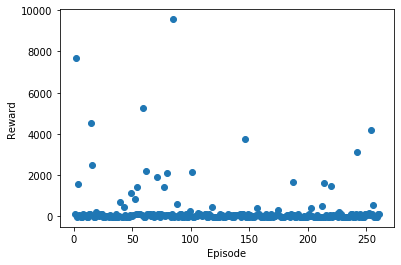

In [13]:
a=rewards_all_episodes
n = 0 
count = 0
n_list=[]
count_list=[]
for i in a :
    for j in i:
        count += j
    count_list.append(sum(i))
    n+=1
    n_list.append(n)
    if n%10 == 0:
        print(n,':',str(count/10)) 
        
ax=plt.scatter(n_list,count_list,marker='o')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [10]:
b=action_all_episodes
step = []
episode=[]
n=1
for i in b:
    step.append(len(i))
    episode.append(n)
    n+=1
print(step)
print('')
print(episode)

[29, 49, 25, 18, 33, 19, 27, 44, 25, 34, 46, 52, 38, 18, 26, 29, 25, 63, 26, 39, 41, 0, 35, 47, 54, 0, 32, 0, 0, 25, 34, 0, 37, 34, 38, 46, 39, 22, 0, 33, 34, 40, 42, 50, 27, 45, 48, 30, 50, 49, 49, 42, 43, 54, 59, 129, 55, 78, 41, 44, 52, 50, 48, 55, 68, 50, 0, 51, 34, 72, 45, 72, 54, 30, 110, 57, 41, 0, 65, 38, 82, 43, 56, 59, 38, 204, 0, 94, 32, 114, 90, 57, 53, 60, 99, 79, 68, 102, 68, 89, 104, 104, 97, 91, 0, 105, 112, 142, 82, 0, 111, 88, 107, 62, 86, 132, 0, 114, 58, 65, 80, 120, 211, 112, 123, 0, 118, 108, 146, 96, 89, 114, 140, 130, 93, 83, 71, 96, 137, 105, 150, 153, 97, 92, 237, 90, 100, 131, 154, 126, 120, 148, 161, 137, 0, 241, 186, 159, 0, 160, 127, 149, 44, 350, 478, 139, 123, 282, 207, 153, 0, 94, 205, 184, 173, 208, 107, 80, 193, 169, 0, 196, 173, 227, 173, 214, 130, 139, 122, 276, 479, 364, 227, 295, 203, 325, 229, 116, 194, 244, 159, 423, 177, 353, 109, 158, 184, 278, 127, 132, 96, 226, 116, 142, 171, 218, 215, 441, 267, 146, 187, 364, 0, 309, 262, 190, 322, 334, 200

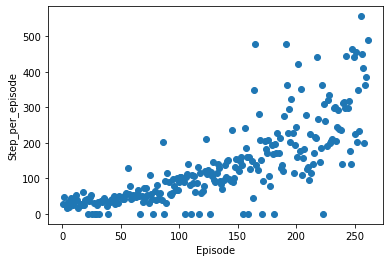

In [11]:
ax=plt.scatter(episode,step,marker='o')
plt.xlabel('Episode')
plt.ylabel('Step_per_episode')
plt.show()

In [12]:
print(brake_count, crash_count, timeout_count)

142 101 0


In [25]:
print(q_table)
q_table[dist_q.index(8.9)].index(max(q_table[dist_q.index(8.9)][:]))

[[-16.086524778877425, -15.190185676977718], [-12.251141802713375, -17.22043616417395], [-15.233597020099397, -8.390507737828253], [-0.24141940210496615, -6.4035268161800785], [-11.614061667817127, -11.36896013212924], [-9.225909951859622, -7.118228905650297], [-3.802436212121766, 3.2925169979864837], [-3.149219137016351, -3.0693208817970885], [-4.568451155987702, 4.48735383182711], [-4.195646254933942, -5.264576595021779], [-3.1781765298602775, -4.424307215655572], [-0.3340217070118596, 12.006623892501565], [4.229880101477619, -4.131877042259553], [0.404552943104064, 0.6703479051254246], [2.264044784991429, 7.183287961188625], [4.479213310575599, 1.443336361146059], [0.9542506881792203, 2.189836849115486], [-0.8297797867563582, 2.5815810379782995], [0.3667827297542864, 1.6182385631852036], [0.3352059096119242, 1.232122637261193], [0.9812182872420425, 0.5569042903958585], [15.00805820874459, 9.540014209483509], [1.8763541985218657, 1.9663827039790476], [3.3934626063457425, 4.1623385792

1

In [35]:
#'------------------------------ Test q_table -----------------------------------'
env = CarEnv()
num_episodes = 300
count = 0
rewards_all_episodes = []
action_all_episodes = []

for episode in tqdm(range(num_episodes)):
    # reset state, but sometimes the server will lag so except the error then reconnect to the server after time.sleep() for 15 sec
    while True:
        try:
            state = env.reset()
            if env.flag == 1:
                break
        except RuntimeError as err:
            RuntimeError_count += 1
            print(err,' ',1)
            while True:
                try:
                    time.sleep(15)                                   #wait for 15 sec
                    env.client = carla.Client('localhost', 2000)     #reconnect to server
                    env.client.set_timeout(10.0)
                    env.world = env.client.get_world() #if cannot reconnect, this line will cause an error ---> jump to the 'except' line
                    blueprint_library = env.world.get_blueprint_library()
                    env.model_3 = blueprint_library.filter('model3')[0]
                    env.world.wait_for_tick()
                    for x in list(world.get_actors())[-3:]:
                        x.destroy()                                  #destroy the last episode vehicle, lidar and collision sensor
                    break
                except RuntimeError as err:
                    RuntimeError_count += 1
                    print(err,' ',RuntimeError_count)
    
    ss=time.time()-env.episode_start
    print('LOOP START :'+str(ss))
    done = False
    rewards_current_episode = []
    action_current_episode = []
    count_step=0
    
    while True:
        action=q_table[dist_q.index(state)].index(max(q_table[dist_q.index(state)][:]))
        time.sleep(0.1)
        action_current_episode.append(action)
        new_state, reward, done, info = env.step(action)
        count_step+=1
        state = new_state
        rewards_current_episode.append(reward)
      
        if done == True:
            break  
    
    print('destroying actors')
    for actor in env.actor_list:
                actor.destroy()
    time.sleep(0.1)
    count+=1
    print('episode number = ',count)
    print('rewards_current_episode = ',rewards_current_episode)
    print('action_current_episode =', action_current_episode)
    print('count_step = ', count_step)
    print(env.collision_hist)

    rewards_all_episodes.append(rewards_current_episode)
    action_all_episodes.append(action_current_episode)



  0%|          | 0/300 [00:00<?, ?it/s]

LOOP START :0.0


ValueError: 22.7 is not in list

In [19]:
xxx()

In [ ]:
print(env.collision_hist)

In [ ]:
print(np.array(q_table))
print()